In [1]:
# Importieren der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from itertools import combinations

In [2]:
#daten einlesen
train_df_initial = pd.read_csv('train.csv')

In [3]:
#Auswahl der doppelte Daten

train_df_initial.drop_duplicates(inplace=True)
train_df_initial.drop(['Id'], axis=1, inplace=True)

train_df_initial.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
# Anzahl NaN pro Spalte und check der Variabeln.
nan_pro_column = train_df_initial.isna().sum()

num_columns_with_NaN = nan_pro_column[nan_pro_column > 0].sort_values(ascending=False)

num_columns_with_NaN
#missing_values_columns =['LotFrontage',  'MasVnrArea', 'GarageCond',  'GarageType', 'GarageYrBlt', 'GarageFinish', 'BsmtFinType1', 'BsmtFinType2'] #raus?


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [6]:
#Bei Feature Electrical, die einzige Zeile löschen, wo es ein Nan gibt.
train_df_initial.dropna(subset=['Electrical'], inplace=True)

In [7]:
# In den Spalten, wo es NaN einen Wert darstellt, wird Nan min 'NA' String ersetzt.
train_df_initial.fillna({'Alley': 'NA'}, inplace=True)
train_df_initial.fillna({'MasVnrType': 'NA'}, inplace=True)
train_df_initial.fillna({'BsmtQual': 'NA'}, inplace=True)
train_df_initial.fillna({'BsmtCond': 'NA'}, inplace=True)
train_df_initial.fillna({'BsmtExposure': 'NA'}, inplace=True)
train_df_initial.fillna({'FirePlaceQu': 'NA'}, inplace=True)
train_df_initial.fillna({'GarageQual': 'NA'}, inplace=True)
train_df_initial.fillna({'GarageQual': 'NA'}, inplace=True)
train_df_initial.fillna({'Fence': 'NA'}, inplace=True)
train_df_initial.fillna({'MiscFeature': 'NA'}, inplace=True)

In [8]:
# Anzahl NaN pro Spalte und check der Variabeln. Endliche Wert der Spalten zu löschen.

nan_pro_column_2 = train_df_initial.isna().sum()

num_columns_with_NaN_2 = nan_pro_column_2[nan_pro_column_2 > 0].sort_values(ascending=False)

missing_values_columns = num_columns_with_NaN_2.index.tolist()

In [9]:
#Aussortieren der Spalten mit fehelende Werte.
train_df_initial.drop(missing_values_columns, axis=1, inplace=True)

In [10]:
#Auswahl der numerischen Spalten, um damit einen ersten Überblick für eine lineare Regression.
numerical_cols = train_df_initial.select_dtypes(include=['int64', 'float64']).columns

train_df_initial_num = train_df_initial[numerical_cols]

In [11]:
train_df_initial_num.info(True)

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1459 non-null   int64
 1   LotArea        1459 non-null   int64
 2   OverallQual    1459 non-null   int64
 3   OverallCond    1459 non-null   int64
 4   YearBuilt      1459 non-null   int64
 5   YearRemodAdd   1459 non-null   int64
 6   BsmtFinSF1     1459 non-null   int64
 7   BsmtFinSF2     1459 non-null   int64
 8   BsmtUnfSF      1459 non-null   int64
 9   TotalBsmtSF    1459 non-null   int64
 10  1stFlrSF       1459 non-null   int64
 11  2ndFlrSF       1459 non-null   int64
 12  LowQualFinSF   1459 non-null   int64
 13  GrLivArea      1459 non-null   int64
 14  BsmtFullBath   1459 non-null   int64
 15  BsmtHalfBath   1459 non-null   int64
 16  FullBath       1459 non-null   int64
 17  HalfBath       1459 non-null   int64
 18  BedroomAbvGr   1459 non-null   int64
 19  KitchenAbvG

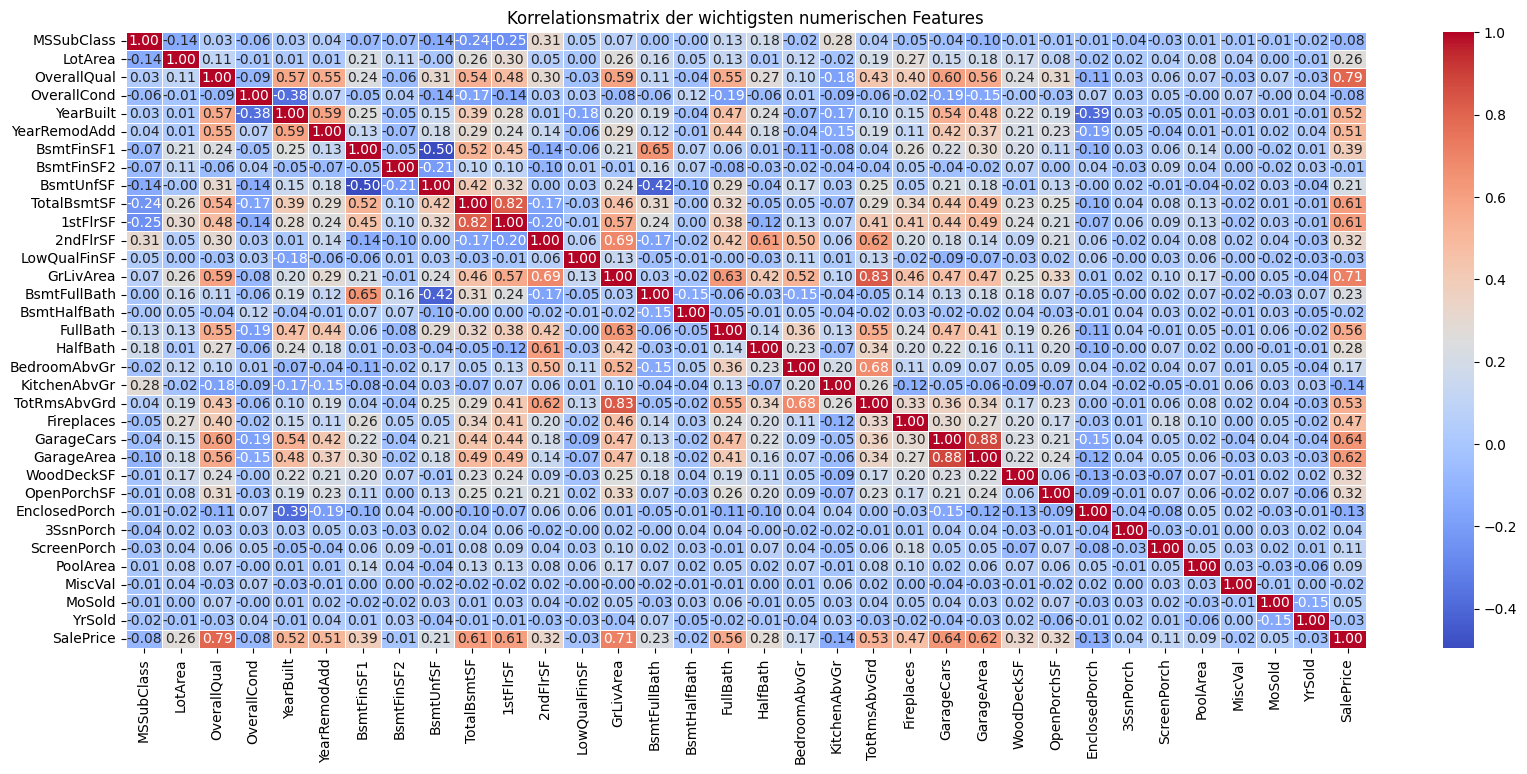

In [ ]:
#1. Numerical Features Selection basierend auf der Korrelationsmatrix.

# Berechne die Korrelationsmatrix für die numerischen Spalten
corr_matrix = train_df_initial[numerical_cols].corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der wichtigsten numerischen Features')
plt.show()

In [13]:
#Auswahl der bedeutesten Variabeln aus einer 'linearen' Perspektive
main_var_maske = corr_matrix['SalePrice'] > 0.45

main_corr_matrix = corr_matrix[main_var_maske]

type(main_corr_matrix.iloc[:, 0]) #Serie

main_columns = main_corr_matrix.iloc[:, 0].index

main_corr_matrix[main_columns]# Keine davon gehört zu Spalten, die viele fehlende Werte haben.

main_columns


Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

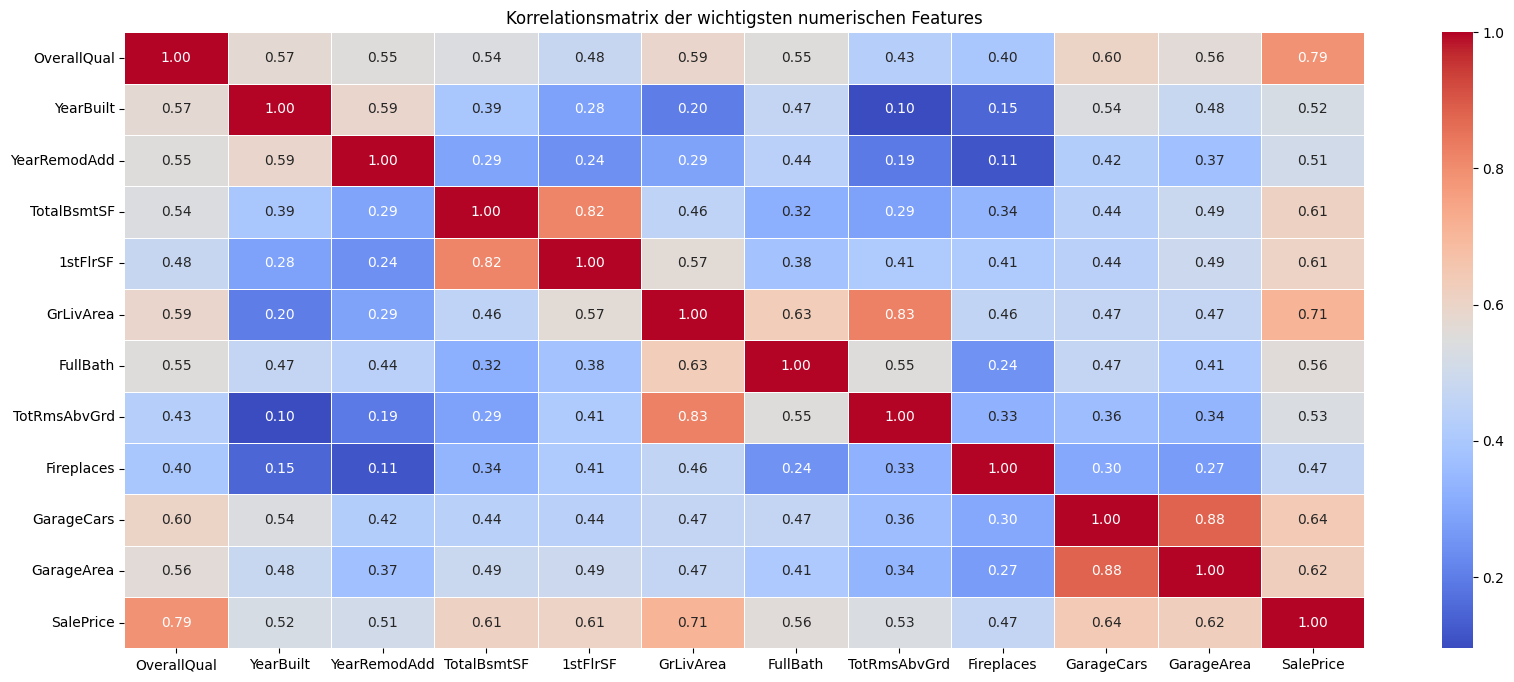

In [14]:
#Visualisierung der bedeutesten Variabeln aus einer linearen Perspektive

corr_matrix_clean = main_corr_matrix[main_columns]

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix_clean, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der wichtigsten numerischen Features')
plt.show()

In [15]:
# Auswahl der Variabel, die NICHT multikollinear sind

vif_data = pd.DataFrame()

X_vif = main_corr_matrix[main_columns]

vif_data["feature"] = X_vif.columns

vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
print(vif_data)

train_df_main = train_df_initial[main_columns]

         feature         VIF
0    OverallQual   64.182623
1      YearBuilt   24.883085
2   YearRemodAdd   11.071210
3    TotalBsmtSF   76.523233
4       1stFlrSF   81.865971
5      GrLivArea  193.285865
6       FullBath   24.602144
7   TotRmsAbvGrd   62.187925
8     Fireplaces    6.410674
9     GarageCars  189.782703
10    GarageArea  167.595322
11     SalePrice  127.477324


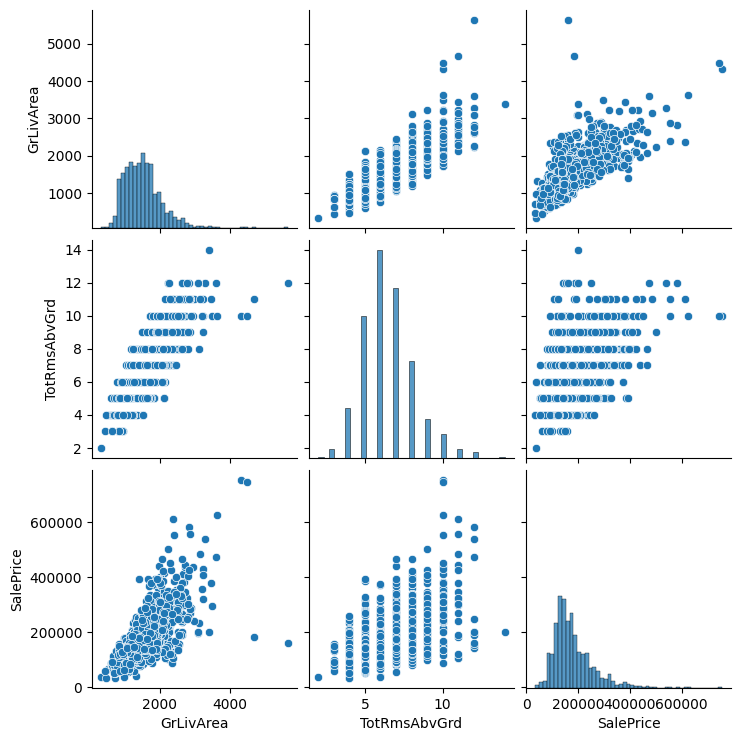

In [16]:
#Check der Features, die das höchste VIF haben und die ähnliche Grösse darstellen

# 'GrLivArea', 'TotRmsAbvGrd' -> above grade (ground) living area square feet / Komplette Räume ab dem Grundlevel
# 'TotalBsmtSF', '1stFlrSF' -> Area des Basements / Area de ersten Stocks
# 'GarageCars','GarageArea'

sns.pairplot(train_df_main, vars=['GrLivArea', 'TotRmsAbvGrd', 'SalePrice'])
plt.show()

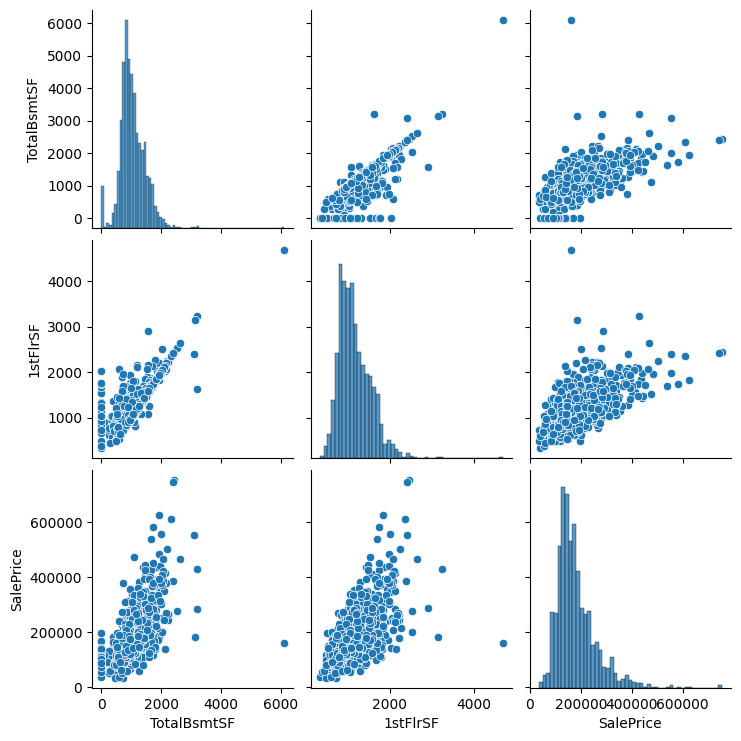

In [17]:
sns.pairplot(train_df_main, vars=['TotalBsmtSF', '1stFlrSF', 'SalePrice'])
plt.show()

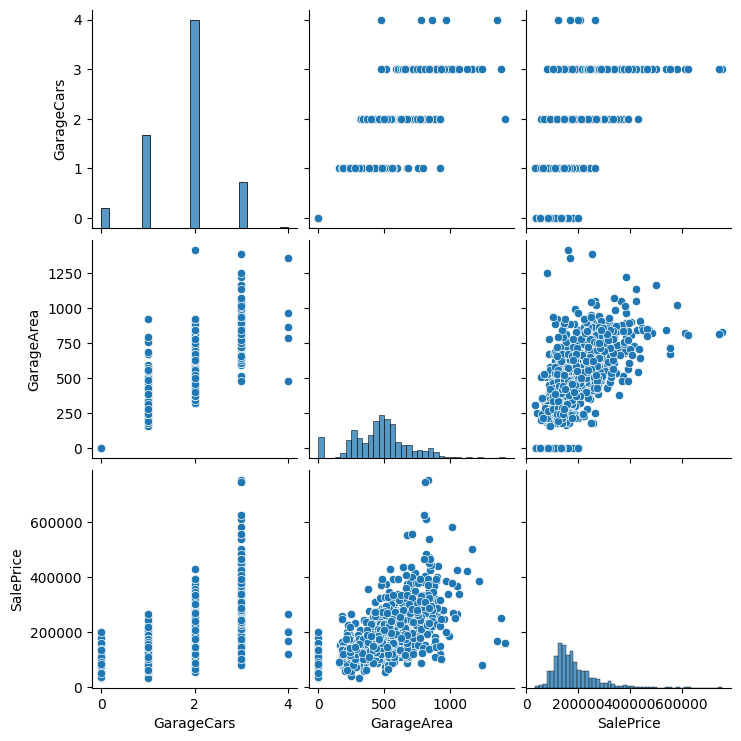

In [18]:
sns.pairplot(train_df_main, vars=['GarageCars','GarageArea', 'SalePrice'])
plt.show()

In [19]:
#Auswahl der Variabeln, die relevant für ein Lineares Regressionsmodel sind.
train_df_main = train_df_initial[main_columns].drop(['1stFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis=1)

clean_main_columns = train_df_main.columns

clean_main_columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea',
       'FullBath', 'Fireplaces', 'GarageArea', 'SalePrice'],
      dtype='object')

In [20]:
#1 Erstes Beispiel einer Lineare Regression mit Korrelationsmatrix Features Selection.

# Daten aufteilen

X = train_df_main[clean_main_columns].drop(['SalePrice'], axis=1)

y = train_df_main[clean_main_columns]['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Merkmale skalieren (WICHTIG!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
model_lr = LinearRegression()

# Modell mit Trainingsdaten trainieren
model_lr.fit(X_train, y_train)

print("Lineare Regression trainiert.")
print(f"Achsenabschnitt (c): {model_lr.intercept_:.2f}")
print(f"Steigung (m): {model_lr.coef_[0]:.2f}")

Lineare Regression trainiert.
Achsenabschnitt (c): -1256918.86
Steigung (m): 20024.03


In [23]:
y_pred_lr = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\nMean Squared Error (MSE): {mse_lr:.2f}")
print(f"R-squared (R²): {r2_lr:.2f}")



Mean Squared Error (MSE): 1039977460.98
R-squared (R²): 0.84


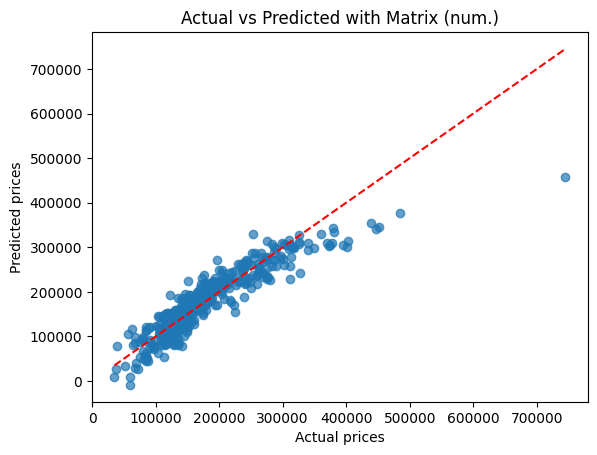

In [24]:
plt.scatter(y_test, y_pred_lr, alpha=0.7)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.title("Actual vs Predicted with Matrix (num.)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [25]:
#2. Features Selection mit F-Anova, nur numerisch.

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif)  
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]
f_scores = selector.scores_[selector.get_support()]
print(f"Selected Features: {selected_features}")
print(f"F-Scores: {f_scores}")

Selected Features: Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea',
       'FullBath', 'Fireplaces', 'GarageArea'],
      dtype='object')
F-Scores: [5.12052197 2.16552847 1.74123263 1.97779457 2.8269887  2.29895928
 1.6034843  2.25558824]


c:\Users\Ella\Desktop\GHProjects\House-Pricing\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(


In [56]:
#2 Lineare Regression Model mit (F-Anova) Features Selection anpassen, nur numerisch.

# Daten aufteilen

X_2 = train_df_main[selected_features]

y_2 = train_df_main[clean_main_columns]['SalePrice']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

# Merkmale skalieren (WICHTIG!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled = scaler.transform(X_test_2)

model_lr_2 = LinearRegression()

# Modell mit Trainingsdaten trainieren
model_lr_2.fit(X_train_2, y_train_2)

print("Lineare Regression mit F-Anova trainiert.")
print(f"Achsenabschnitt mit F-Anova (c): {model_lr_2.intercept_:.2f}")
print(f"Steigung mit F-Anova (m): {model_lr_2.coef_[0]:.2f}")

y_pred_lr_2 = model_lr_2.predict(X_test_2)

mse_lr_2 = mean_squared_error(y_test_2, y_pred_lr_2)
r2_lr_2 = r2_score(y_test_2, y_pred_lr_2)

print(f"\nMean Squared Error mit F-Anova (MSE): {mse_lr_2:.2f}")
print(f"R-squared mit F-Anova (R²): {r2_lr_2:.2f}")

Lineare Regression mit F-Anova trainiert.
Achsenabschnitt mit F-Anova (c): -1256918.86
Steigung mit F-Anova (m): 20024.03

Mean Squared Error mit F-Anova (MSE): 1039977460.98
R-squared mit F-Anova (R²): 0.84


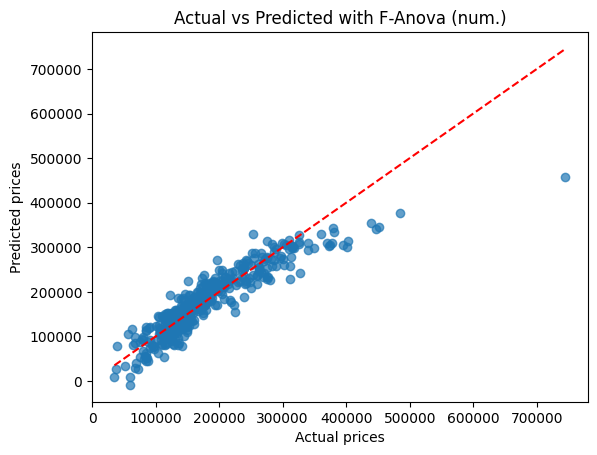

In [57]:
plt.scatter(y_test_2, y_pred_lr_2, alpha=0.7)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.title("Actual vs Predicted with F-Anova (num.)")
plt.plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], 'r--') 
plt.show()

In [58]:
#Kategorische Variablen zur Lineare Regression werden hinzugefügt. Nach Hintegrundkenntisse.

categorical_rel_features = ['HouseStyle', 'Condition1', 'Neighborhood', 'MSZoning', 'SaleCondition']

cat_train_df = train_df_initial[categorical_rel_features]

cat_train_df_encoded = pd.get_dummies(cat_train_df, columns=categorical_rel_features, drop_first=True)



In [59]:
#Ganze Dataframen. numerisches und kategorische Spalten.
whole_train_df = pd.concat([train_df_main[selected_features], cat_train_df_encoded], axis=1)

In [60]:
#3 Lineare Regression Model anpassen, numerisch mit Matrix und kategorische mit Hintergrundkenntnisse und Analyse).

X_c = whole_train_df

y_c = train_df_main['SalePrice']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.3, random_state=42)

# Merkmale skalieren (WICHTIG!)
scaler = StandardScaler()
X_train_scaled_c = scaler.fit_transform(X_train_c)
X_test_scaled_c = scaler.transform(X_test_c)

model_lr_c = LinearRegression()

# Modell mit Trainingsdaten trainieren
model_lr_c.fit(X_train_scaled_c, y_train_c)

print("Lineare Regression mit Matrix und Hintegrundkenntnisse (bei Kat.) trainiert.")
print(f"Achsenabschnitt mit Matrix und Hintegrundkenntnisse (bei Kat.): {model_lr_c.intercept_:.2f}")
print(f"Steigung mit Matrix und Hintegrundkenntnisse (bei Kat.): {model_lr_c.coef_[0]:.2f}")

y_pred_lr_c = model_lr_c.predict(X_test_scaled_c)

mse_lr_c = mean_squared_error(y_test_c, y_pred_lr_c)
r2_lr_c = r2_score(y_test_c, y_pred_lr_c)

print(f"\nMean Squared Error mit Matrix und Hintegrundkenntnisse (bei Kat.) (MSE): {mse_lr_c:.2f}")
print(f"R-squared mit Matrix und Hintegrundkenntnisse (bei Kat.) (R²): {r2_lr_c:.2f}")


Lineare Regression mit Matrix und Hintegrundkenntnisse (bei Kat.) trainiert.
Achsenabschnitt mit Matrix und Hintegrundkenntnisse (bei Kat.): 181126.18
Steigung mit Matrix und Hintegrundkenntnisse (bei Kat.): 20752.42

Mean Squared Error mit Matrix und Hintegrundkenntnisse (bei Kat.) (MSE): 952953511.19
R-squared mit Matrix und Hintegrundkenntnisse (bei Kat.) (R²): 0.85


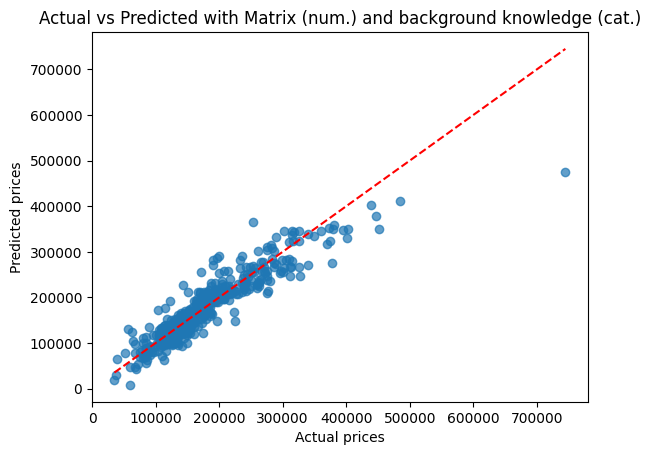

In [61]:
plt.scatter(y_test_c, y_pred_lr_c, alpha=0.7)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.title("Actual vs Predicted with Matrix (num.) and background knowledge (cat.)")
plt.plot([y_test_c.min(), y_test_c.max()], [y_test_c.min(), y_test_c.max()], 'r--') 
plt.show()

In [62]:
#4 Lineare Regression mit numerischen Spalten und Kategorischen Spalten nach F-Anova Test.

categorical_rel_features_Anova = ['MSZoning', 'Utilities']

cat_train_df_Anova = train_df_initial[categorical_rel_features_Anova]

cat_train_df_encoded_Anova = pd.get_dummies(cat_train_df_Anova, columns=categorical_rel_features_Anova, drop_first=True)

whole_train_df_Anova = pd.concat([train_df_main[selected_features], cat_train_df_encoded_Anova], axis=1)



In [63]:

X_Anova = whole_train_df_Anova

y_Anova = train_df_main['SalePrice']

X_train_Anova, X_test_Anova, y_train_Anova, y_test_Anova = train_test_split(X_Anova, y_Anova, test_size=0.3, random_state=42)

# Merkmale skalieren (WICHTIG!)
scaler = StandardScaler()
X_train_scaled_Anova = scaler.fit_transform(X_train_Anova)
X_test_scaled_Anova = scaler.transform(X_test_Anova)

model_lr_Anova = LinearRegression()

# Modell mit Trainingsdaten trainieren
model_lr_Anova.fit(X_train_scaled_Anova, y_train_Anova)

print("Lineare Regression mit F-Anova trainiert.")
print(f"Achsenabschnitt mit F-Anova (c): {model_lr_Anova.intercept_:.2f}")
print(f"Steigung mit F-Anova (m): {model_lr_Anova.coef_[0]:.2f}")

y_pred_lr_Anova = model_lr_Anova.predict(X_test_scaled_Anova)

mse_lr_Anova = mean_squared_error(y_test_Anova, y_pred_lr_Anova)
r2_lr_Anova = r2_score(y_test_Anova, y_pred_lr_Anova)

print(f"\nMean Squared Error mit Kategorischen Variabeln (MSE): {mse_lr_Anova:.2f}")
print(f"R-squared mit Kategorischen Variabeln (R²): {r2_lr_Anova:.2f}")

Lineare Regression mit F-Anova trainiert.
Achsenabschnitt mit F-Anova (c): 181126.18
Steigung mit F-Anova (m): 28285.85

Mean Squared Error mit Kategorischen Variabeln (MSE): 1016742746.68
R-squared mit Kategorischen Variabeln (R²): 0.84


In [64]:
#Test daten einlesen
test_df_initial = pd.read_csv('test.csv')

In [65]:
#Erste Infos
test_df_initial.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [66]:
test_df_initial.drop_duplicates(inplace=True)
test_df_initial.drop(['Id'], axis=1, inplace=True)

test_df_initial.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [67]:
test_df_initial.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [68]:
nan_pro_column = test_df_initial.isna().sum()

num_columns_with_NaN = nan_pro_column[nan_pro_column > 0].sort_values(ascending=False)

num_columns_with_NaN

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageQual        78
GarageCond        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64

In [69]:
# In den Spalten, wo es NaN einen Wert darstellt, wird Nan min 'NA' String ersetzt.
test_df_initial.fillna({'Alley': 'NA'}, inplace=True)
test_df_initial.fillna({'MasVnrType': 'NA'}, inplace=True)
test_df_initial.fillna({'BsmtQual': 'NA'}, inplace=True)
test_df_initial.fillna({'BsmtCond': 'NA'}, inplace=True)
test_df_initial.fillna({'BsmtExposure': 'NA'}, inplace=True)
test_df_initial.fillna({'FirePlaceQu': 'NA'}, inplace=True)
test_df_initial.fillna({'GarageQual': 'NA'}, inplace=True)
test_df_initial.fillna({'GarageQual': 'NA'}, inplace=True)
test_df_initial.fillna({'Fence': 'NA'}, inplace=True)
test_df_initial.fillna({'MiscFeature': 'NA'}, inplace=True)

In [70]:
#Nach data cleaning Spalten zu behalten, und check von Nan Werten.

clean_main_columns = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea',
       'FullBath', 'Fireplaces', 'GarageArea']

test_df_num = test_df_initial[clean_main_columns]

test_df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   YearBuilt     1459 non-null   int64  
 2   YearRemodAdd  1459 non-null   int64  
 3   TotalBsmtSF   1458 non-null   float64
 4   GrLivArea     1459 non-null   int64  
 5   FullBath      1459 non-null   int64  
 6   Fireplaces    1459 non-null   int64  
 7   GarageArea    1458 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 91.3 KB


In [71]:
#Nur zwei fehlende Werte (num.) werden mit Mittelwert eingefüllz.

test_df_num['TotalBsmtSF'] = test_df_num['TotalBsmtSF'].fillna(test_df_num['TotalBsmtSF'].mean())
test_df_num['GarageArea'] = test_df_num['GarageArea'].fillna(test_df_num['GarageArea'].mean())

test_df_num.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   YearBuilt     1459 non-null   int64  
 2   YearRemodAdd  1459 non-null   int64  
 3   TotalBsmtSF   1459 non-null   float64
 4   GrLivArea     1459 non-null   int64  
 5   FullBath      1459 non-null   int64  
 6   Fireplaces    1459 non-null   int64  
 7   GarageArea    1459 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 91.3 KB


C:\Users\Ella\AppData\Local\Temp\ipykernel_20840\913326034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_num['TotalBsmtSF'] = test_df_num['TotalBsmtSF'].fillna(test_df_num['TotalBsmtSF'].mean())
C:\Users\Ella\AppData\Local\Temp\ipykernel_20840\913326034.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_num['GarageArea'] = test_df_num['GarageArea'].fillna(test_df_num['GarageArea'].mean())


In [72]:
#Kategorische Variablen zur Lineare Regression werden hinzugefügt. Nach Hintegrundkenntisse.

categorical_rel_features = ['HouseStyle', 'Condition1', 'Neighborhood', 'MSZoning', 'SaleCondition']

cat_test_df_encoded = pd.get_dummies(test_df_initial[categorical_rel_features], columns=categorical_rel_features, drop_first=True)

cat_test_df_encoded

,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,...,Neighborhood_Veenker,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
4,False,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
1455,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
1456,False,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1457,False,False,False,False,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False


In [73]:
#Ganze Dataframen. numerisches und kategorische Spalten.
whole_test_df = pd.concat([test_df_num, cat_test_df_encoded], axis=1)

whole_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallQual            1459 non-null   int64  
 1   YearBuilt              1459 non-null   int64  
 2   YearRemodAdd           1459 non-null   int64  
 3   TotalBsmtSF            1459 non-null   float64
 4   GrLivArea              1459 non-null   int64  
 5   FullBath               1459 non-null   int64  
 6   Fireplaces             1459 non-null   int64  
 7   GarageArea             1459 non-null   float64
 8   HouseStyle_1.5Unf      1459 non-null   bool   
 9   HouseStyle_1Story      1459 non-null   bool   
 10  HouseStyle_2.5Unf      1459 non-null   bool   
 11  HouseStyle_2Story      1459 non-null   bool   
 12  HouseStyle_SFoyer      1459 non-null   bool   
 13  HouseStyle_SLvl        1459 non-null   bool   
 14  Condition1_Feedr       1459 non-null   bool   
 15  Cond